# Magma Dynamics Practical 7: Numerical Modelling of Diffusion #
## John Maclennan, February 2021 ##

## Numerical Solutions of Partial Differential Equations

In the last practical you saw that simple analytical solutions involving the error function can provide good fits to observations in cases where the boundary conditions and initial conditions are also simple and well-constrained. You will also have realised that that uncertainty in temperature can translate into substantial uncertainties in diffusion time. Practically speaking, it is often necessary to use Numerical Methods to solve for problems in natural systems - computational apporaches to the solution of differential equations. Finite difference techniques are relatively straightforward to apply and have been commonly used. Our new method, **DFENS** ([Mutch et al., 2020](https://www.essoar.org/doi/10.1002/essoar.10503709.1)), which has been constructed to extract robust estimates of timescales, along with well-quantified uncertainties in complex 3D geometries with spatially varying and anisotropic $D$s, combines a finite element solver (FEniCS) along with the MultiNest Bayesian nested sampling algorithm. This level of complexity is not yet possible to deal with in a practical, so we will stick to the numerical solvers provided by the R package deSolve, which is called in the chunk below.

The problem that we will address is that of Mg diffusion in plagioclase. Since Mg is at low concentration in the plagioclase, the interdiffusion of Mg (apparently through the tetrahedral sites) is very similar to the tracer diffusion for Mg. Interestingly, the partition coefficient for Mg between plagioclase and melt, $K_{Mg}$, is dependent upon the Anorthite content of the plagioclase. One suggested model for this partitioning behaviour is 

$RT\ln{K_{Mg}} = 1000 \times(-34.1 X_{An} - 17.4)$ 

One obvious consequence of this relationship is that plagioclase with varying An contents will have varying Mg contents when they are in equilibrium for Mg with the same melt. 

### A Natural Example from Iceland

Take a look at the image below, from [Mutch et al., 2020](https://www.essoar.org/doi/10.1002/essoar.10503709.1). This is taken from a sample of a pillow lava rim in the marvellously porphyritic Skuggafjoll eruption [(Neave et al., 2014)](https://academic.oup.com/petrology/article/55/12/2311/1558945). The backscattered electron intensity in the map in (a) is related to the anorthite content, $X_{An}$ (mole fraction) of the plagioclase. The location of the compositional profiles shown in c,d are provided on (a). The model fits are shown as red lines, and the initial conditions as grey dashed lines. In (b) you see the output of the DFENS model, showing the T-t distribution of model fits. 

![BSE map of a plagioclase from Skuggafjoll](./fig1.png)

**Q1) What do you think might be the cause of the compositional step in $X_{An}$ and Mg in the plagioclase?**

A1) Answer here

**Q2) How might you expect $X_{An}$ and Mg to correlate in the plagioclase during growth? Justify your answer.**

A2) Answer here

**Q3) How might you expect $X_{An}$ and Mg to correlate in a single crystal that is zoned in $X_{An}$ but in equilibrium with a single liquid for Mg?**

A3) Answer here

**Q4) What do you think the significance of plot (e) is?**

A4) Answer here

### A Synthetic Profile Based on Icelandic Observations 
Dr Mutch has prepared some synthetic data with the key characteristics of the Icelandic observations from Skuggafjoll. You can read it in as follows, and convert into a data frame for manipulation and plotting.

In [2]:
import pandas as pd # import pandas package for data handling
syn_df = pd.read_csv('./syn_data.csv') # 
syn_df

,Unnamed: 0,Distance,Mg,Mg_sd,Xan
0,0,0,1054.717992,10,0.78
1,1,5,1047.291183,10,0.78
2,2,10,1046.519864,10,0.78
3,3,15,1054.859361,10,0.78
4,4,20,1059.976296,10,0.78
...,...,...,...,...,...
76,76,380,993.455156,10,0.90
77,77,385,984.656140,10,0.90
78,78,390,991.383875,10,0.90
79,79,395,992.722821,10,0.90


Plot up the data. This example is using the inbuilt plotting functions in Pandas. You can try to change symbol colour, shape, size and also to edit the labels (add units - microns for distance axis) if you want to aim for publication quality.

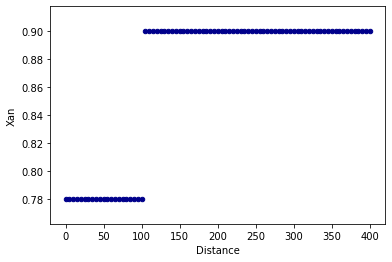

In [4]:
ax1 = syn_df.plot.scatter(x='Distance',
                      y='Xan',
                      c='DarkBlue') # this uses some in-built plot functions in Pandas

Add a code cell in below and make a plot to show the variation in Mg content with distance in the plagioclase. 

### ADD A CELL HERE ###

Clearly, it is not a sensible idea to try to fit a diffusion profile to the observed Mg concentration. This needs to be corrected somehow in order to take account of the variation in the Mg activity coefficient that is associated with the variation in the An content of the plagioclase. One option here is to calculate the composition of the liquid that would be in equilibrium with each plagioclase point according to the partitioning model above.

**Q5) Use the partioning equation and your Python skills to make a plot of this equilibrium liquid composition**

In [ ]:
# A5 Put your code in the chunk here. Use T=1190 deg C.

### Numerical Modelling

Now, lets look at some numerical modelling of diffusion. This is a simple approach 

The code chunk below sets up the function name and parameters for tracking the evolution of concentration via diffusion. Note the relationship between these numerical terms and the terms in Fick's first and second laws  

Next, we provide some information about $D$ (which will be changed later) and the spatial grid

In [5]:
## the model parameters
## Mg in Plagioclase
D         = 1.e-17    # m2/s-1  diffusion coefficient
delx      = 5.e-06      # m width  of boxes
Nx  = 100 # number of boxes
L = delx*Nx
T = 1000.*365.25*24.*60.*60. # years in seconds
a = D # for passing to the solver
F = 0.4 # dimensionless number which defines the timestep (see code below)
#umin = 400. # ppm - minimum value for plotting
#umax = 2000. # ppm - for plotting
umin = 30000. # ppm - minimum value for plotting
umax = 60000. # ppm - for plotting

Next, we provide a step-like initial condition that is consistent with the boundary conditions from above.

In [6]:
def I(x): ## Initial conditions 
#    return 800 if x > 1.E-04 else 1200 # for plag concentrations - 800 ppm Mg in core, 1200 ppm Mg in rim
    return 52000 if x > 1.E-04 else 40000 # for equilibrium melt concentrations from above



Finally, we run the numerical model using a simple finite difference approach. 

In [41]:
#Functions for solving a 1D diffusion equations of simplest types
#(constant coefficient, no source term):
#      u_t = a*u_xx on (0,L)
# with boundary conditions u=0 on x=0,L, for t in (0,T].
# Initial condition: u(x,0)=I(x).
#The following naming convention of variables are used.
#===== ==========================================================
#Name  Description
#===== ==========================================================
#Nx    The total number of mesh cells; mesh points are numbered
#      from 0 to Nx.
#F     The dimensionless number a*dt/dx**2, which implicitly
#      specifies the time step.
#T     The stop time for the simulation.
#I     Initial condition (Python function of x).
#a     Variable coefficient (constant).
#L     Length of the domain ([0,L]).
#x     Mesh points in space.
#t     Mesh points in time.
#n     Index counter in time.
#u     Unknown at current/new time level.
#u_1   u at the previous time level.
#dx    Constant mesh spacing in x.
#dt    Constant mesh spacing in t.
#===== ==========================================================
#user_action is a function of (u, x, t, n), u[i] is the solution at
#spatial mesh point x[i] at time t[n], where the calling code
#can add visualization, error computations, data analysis,
#store solutions, etc.

import sys, time
#from scitools.std import *
import scipy.sparse
import scipy.sparse.linalg
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

def solver_FE_simple(I, a, L, Nx, F, T):
    """
    Simplest expression of the computational algorithm
    using the Forward Euler method and explicit Python loops.
    For this method F <= 0.5 for stability.
    """
    import time
    t0 = time.clock()

    x = np.linspace(0, L, Nx+1)   # mesh points in space
    dx = x[1] - x[0]
    dt = F*dx**2/a
    Nt = int(round(T/float(dt)))
    t = np.linspace(0, T, Nt+1)# mesh points in time
    spy = 365.25*24.*60.*60.
    ty = np.divide(t,spy)
    u   = np.zeros(Nx+1)
    u_1 = np.zeros(Nx+1)

    # Set initial condition u(x,0) = I(x)
    for i in range(0, Nx+1):
        u_1[i] = I(x[i])

    for n in range(0, Nt):
        # Compute u at inner mesh points
        for i in range(1, Nx):
            u[i] = u_1[i] + F*(u_1[i-1] - 2*u_1[i] + u_1[i+1])

        # Insert boundary conditions
        u[0] = I(0);  u[Nx] = I(L)
        plt.clf()
        plt.title('Time in Years=%f' %ty[n])
        plt.plot(x*1.E06, u)
        plt.scatter(syn_df['Distance'],syn_df['Mgl'],c = "red")
        plt.xlim(0,L*1.E06)
        display.clear_output(wait=True)
        display.display(plt.gcf()) 

        #, 'r-', axis=[0, L, umin, umax], title='t=%f' % t[n])
        
        # Switch variables before next step
        u_1, u = u, u_1

    t1 = time.clock()
    return u, x, t, t1-t0


KeyboardInterrupt: 

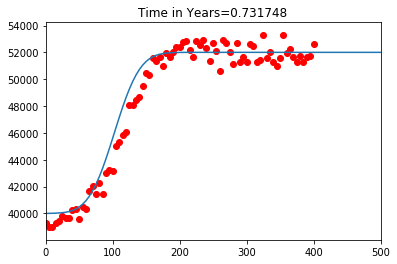

In [42]:
concs = solver_FE_simple(I, a, L, Nx, F, T)

**Verify that your solver is working, and producing solutions that look similar to that expected for evolution of a compositional step according the analytical solution** 

**Q6) Edit the chunks of code to make and plot a diffusion model that matches the synthetic data profile from Q5.**

You should use the temperature and diffusion model from the chunk below to do this. The Mg diffusion in plagioclase model from [Faak et al., (2013)](https://ac.els-cdn.com/S0016703713002731/1-s2.0-S0016703713002731-main.pdf?_tid=ef2a6059-0920-4603-bb1b-ee6eaf4baf34&acdnat=1549574975_94b7113bfb160b4e360a523409080c66) can be used to set $D$, as shown in the box below.

In [43]:
Tc = 1190 # degrees C
Tk = Tc +273.15 # K
asio2 = 0.3 # silica activity in melt
D0 = 1.25e-04 # m2s-1
Q = 320924.0 # activation energy, J mol-1
R = 8.314 # J mol-1 K-1
DF = D0 * np.exp(-Q/(R*Tk)) * np.power(asio2,2.6)

If you want to add the observations to the plot then you will need to recover them from the Pandas dataframe above.

**Q7) What diffusion timescale is required to match the synthetic profile?**

A7) About a year. Clearly there is huge uncertainty here, and any publishable approach would pay attention to quantifying and minimising the misoft between the model and the data. 

**Q8) What is the physical significance of this timescale in terms of eruptive processes?**

A8) This is the timescale between the rapid growth of the plagioclase rim (as judged from textures) and eruption and quenching of the profile. It likely corresponds to a time of mush disaggregation or injection of new magma into the chamber - but we need to carry careful petrological work to establish this point. Check out the preprint by Euan Mutch on Essoar about this very piece eruption!  

### We Cheated - but not too badly!

The eagle-eyed amongst you make have noticed that the numerical diffusion set-up above is not correct. Our Flux term as defined in one of the chunks is designed as a numerical approximation of Fick's first law, $F=-D (\partial C / \partial x)$. However, in the case where the activity coefficient, $\gamma$ is not constant across the crystal, this approximation is not correct. Take a look at the correct expression for the flux in this case as derived in [Costa et al. (2003)](https://ac.els-cdn.com/S0016703702013455/1-s2.0-S0016703702013455-main.pdf?_tid=008d735d-7ed8-4a95-bfa5-c69b5d8c5c50&acdnat=1549572758_8ccbafe723ac4574c2ceb027ccb1c696), Equation 5. If you have the time and the inclination, you could try to work out if this extra term is going to make a significant difference to our model. If so, you might consider including this term in the solver expression for flux.
